In [2]:
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal
import numpy as np
import pandas as pd
import lmfit as lmfit
plt.rc('font', family='serif')

In [3]:
cols = ["q", "I"]
data = pd.read_csv("teshi.dat", names=cols, sep=" ")

In [4]:
data_grammer = pd.read_csv("Grammer_data_1.dat", names=cols, sep="\t")

### PPF

In [90]:
def piecewise_power(x, A1, b1, A2, b2, q0):
    if x < q0:
        return A1*np.power(x, -b1)
    else:
        return A2*np.power(x, -b2)
def piecewise_power_fit_1(x, b1):
    A2= 0.0467
    b2= 3.9764
    A1= A2*np.power(q0, b1-b2)
    result = x.copy()
    result = A1*np.power(x, -b1)
    return result
def piecewise_power_fit_2(x, A2, b2):
    result = x.copy()
    result = A2*np.power(x, -b2)
    return result

In [34]:
def piecewise_power_xs(x):
    k = 0.6947*np.sqrt(x*1e+3)
    A1=132.869
    b1=1.33605
    A2=0.0519763
    b2=3.97314
    Q0=0.0510821
    return (2*np.pi/(k*k))*(A1/(-b1+2)*np.power(Q0,-b1+2) + A2/(-b2+2)*np.power(2*k,-b2+2) - A2/(-b2+2)*np.power(Q0,-b2+2))

In [82]:
A2*np.power(q0, b1-b2)

132.50032427821176

[0.04673549 3.97649845]
[1.3539994]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


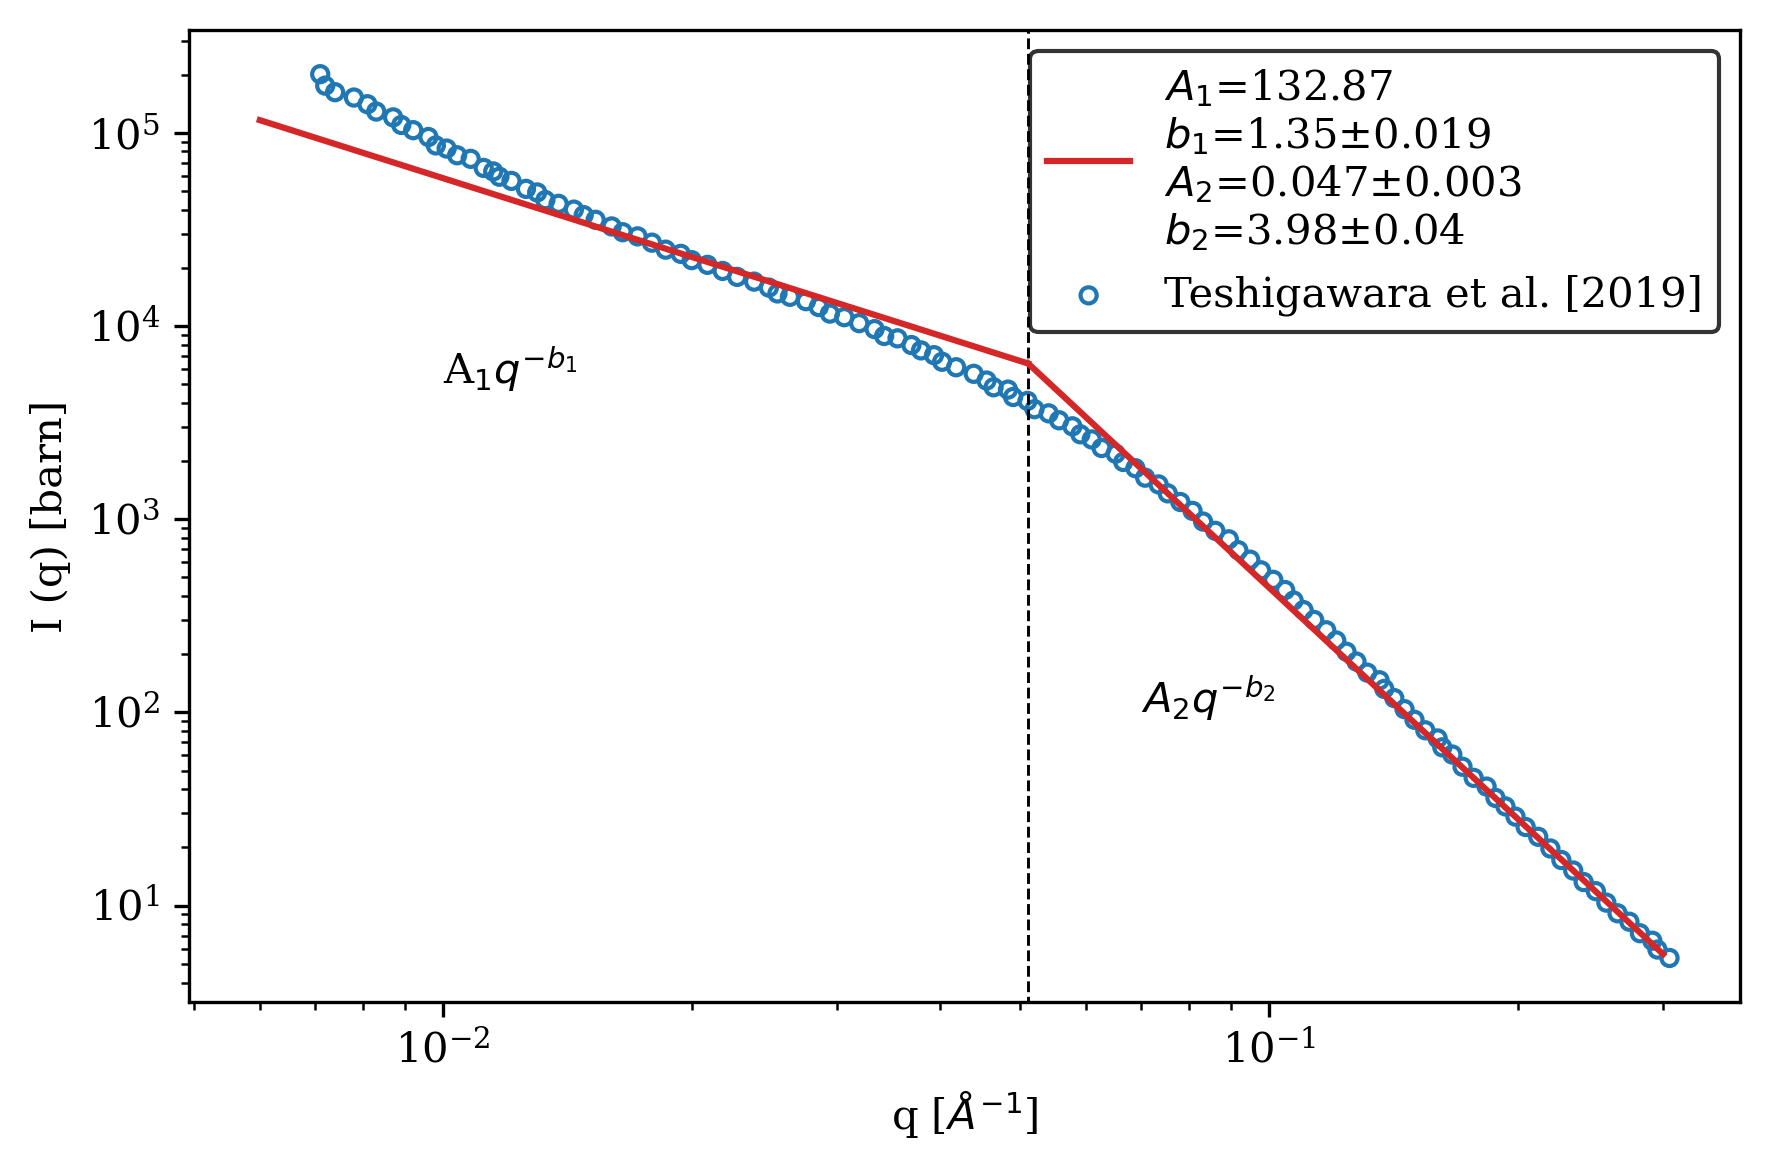

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.scatter(data["q"], data["I"], s=15, facecolors='none',
            edgecolors="tab:blue", label="Teshigawara et al. [2019]")

A1=132.869
b1=1.33605
A2=0.0519763
b2=3.97314
q0=0.0510821
mask_1 = (data["q"] < 0.051) & (data["q"] > 0.015)
mask_2 = data["q"] > 0.2
popt_2, pcov_2= curve_fit(piecewise_power_fit_2,
                       data["q"][mask_2],
                       data["I"][mask_2],
                       p0=[0.05,3.97]
                       )
perr_2= np.sqrt(np.diag(pcov_2))
print(popt_2)
x_fit_2 = [x for x in np.linspace(q0, 0.3, 1000)]
y_fit_2 = piecewise_power_fit_2(pd.Series(x_fit_2),*popt_2)

popt_1, pcov_1= curve_fit(piecewise_power_fit_1,
                       data["q"][mask_1],
                       data["I"][mask_1],
                       p0=[1.33]
                       )
perr_1= np.sqrt(np.diag(pcov_1))
print(popt_1)
x_fit_1 = [x for x in np.linspace(0.006, q0, 1000)]
y_fit_1 = piecewise_power_fit_1(pd.Series(x_fit_1),*popt_1)

# Graphical decorators
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
# plt.vlines(q1,ymin,ymax)
ax.annotate(r'$Q_0$',
            xy=(q0+0.005, 0.7)
            )
ax.annotate(r'A$_1q^{-b_1}$',
            xy=(0.01, 5e3)
            )
plt.axvspan(xmin, q0, facecolor="None",ec="k", ls="dashed",lw=0.7,snap=True)

ax.annotate(r'$A_2q^{-b_2}$',
            xy=(0.07, 100)
            )

plt.plot(x_fit_2, y_fit_2, c="tab:red", label=f'$A_1$={A1:.2f}\n$b_1$={popt_1[0]:.2f}$\pm${perr_1[0]:.3f}\n$A_2$={popt_2[0]:.3f}$\pm${perr_2[0]:.3f}\n$b_2$={popt_2[1]:.2f}$\pm${perr_2[1]:.2f}')
plt.plot(x_fit_1, y_fit_1, c="tab:red", label=None)
leg = ax.legend()
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(1)
plt.xscale("log")
plt.xlabel("q [$Å^{-1}$]")
plt.ylabel("I (q) [barn]")
plt.yscale("log")
# plt.grid(ls=":",which="both")
plt.tight_layout()
plt.savefig("plots/PPF_fit.eps", dpi=300)
plt.savefig("plots/PPF_fit.png", dpi=300)
plt.show()

### Fit using GP model + power law

In [94]:
def GuinierANDPorod(x, A, s, rg, m):
    result = x.copy()
    q2 = 1.0/rg*np.sqrt((m-s)*(3-s)/2)
    B = np.power(q2, m-s)*np.exp((-q2**2*rg**2)/(3-s))
    mask = result < q2
    result[mask] = np.power(x, -s)*np.exp((-x**2*rg**2)/(3-s))
    result[np.invert(mask)] = B*np.power(x, -m)
    return A*result


[66.40901846  1.50279313 14.64271592  4.14778786]
[2.15457679]
q2:  0.09609851492894372  C:  4.3229504598307535  B:  0.00054317235738064
Relative diff. @q2:  -0.038342575535127155


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


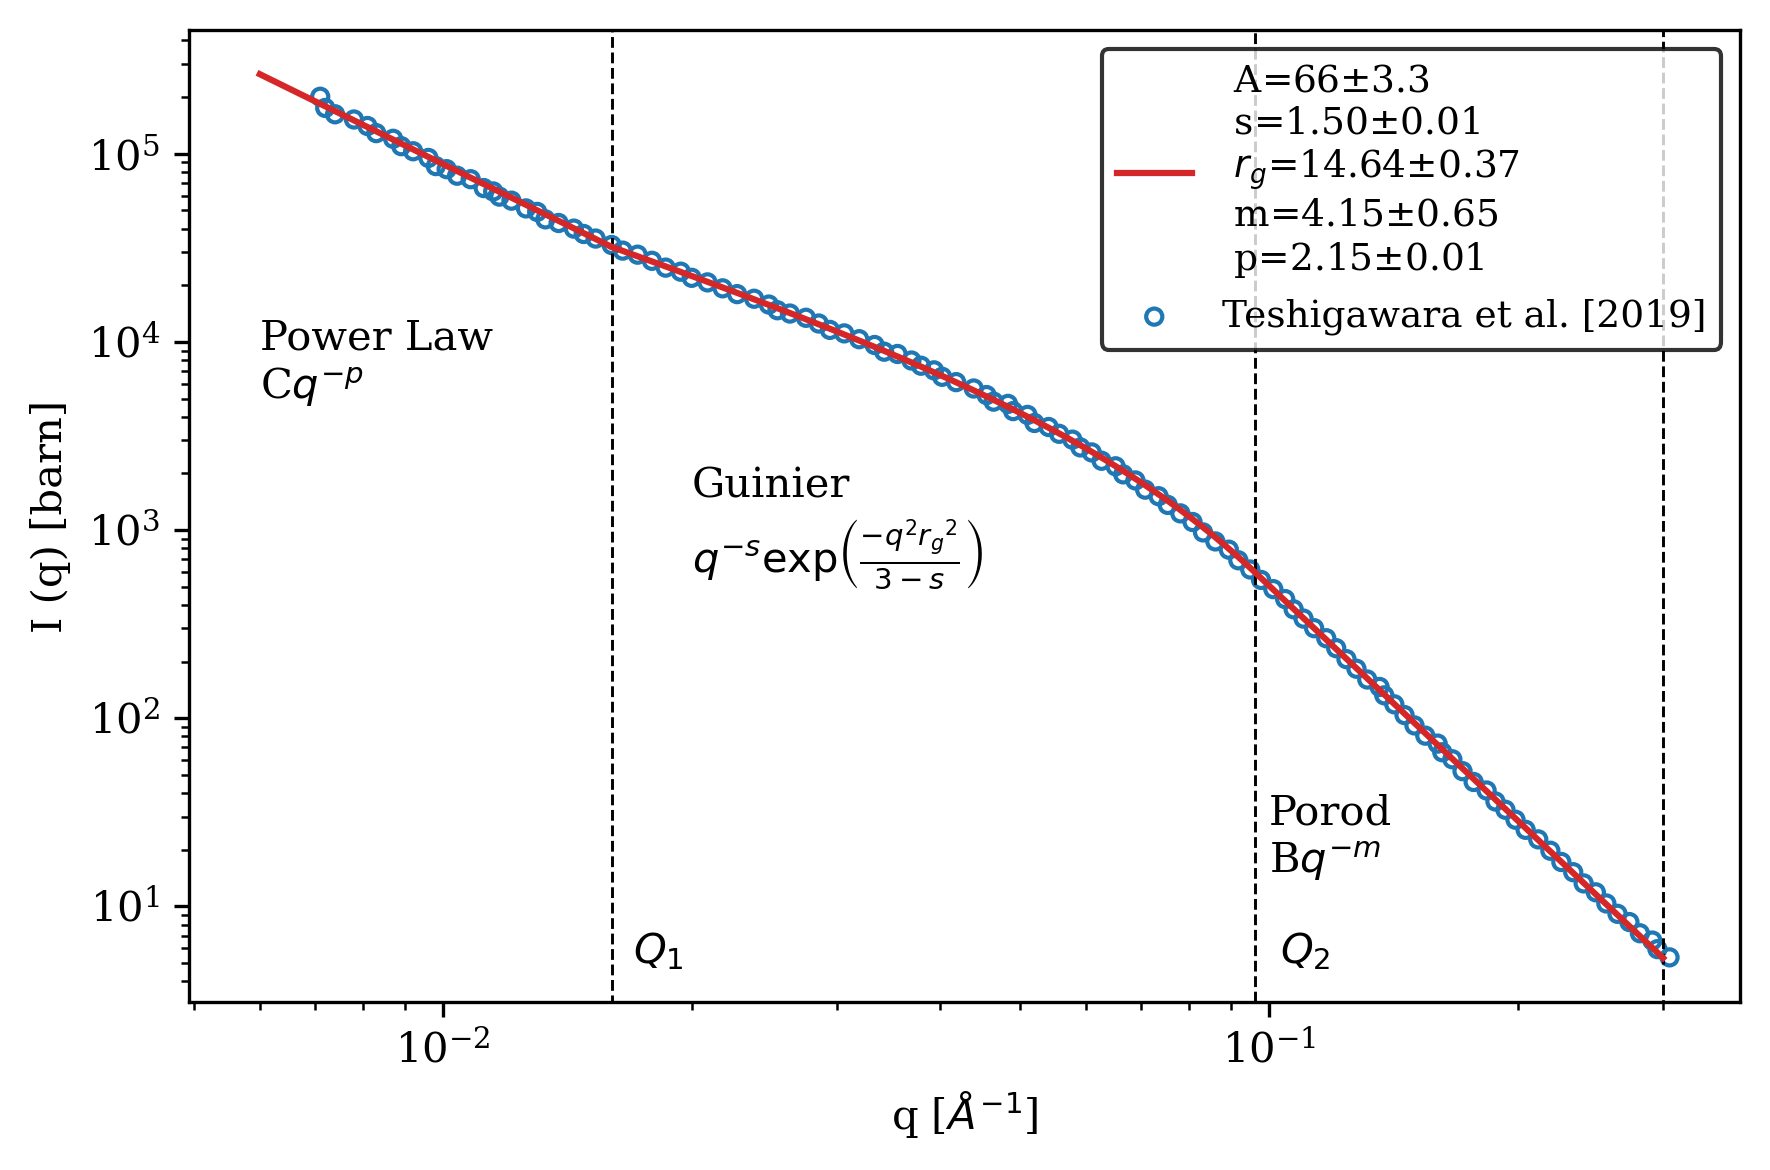

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
q1 = 0.016
mask_fit_PL = (data["q"] > 0.003) & (data["q"] < q1)
mask_fit_guinierANDporod = (data["q"] > q1) & (data["q"] < 0.3)

popt, pcov = curve_fit(GuinierANDPorod,
                       data["q"][mask_fit_guinierANDporod],
                       data["I"][mask_fit_guinierANDporod],
                       p0=[1e2, 1.4, 16, 3.7, ],
                       bounds=((0, 1, 0, 3), (np.inf, np.inf, 20, 10))
                       )
perr = np.sqrt(np.diag(pcov))
print(popt)


def power_law2(x, p):
    C = popt[0]*np.power(q1, p-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
    return C*np.power(x, -p)


popt2, pcov2 = curve_fit(power_law2,
                         data["q"][mask_fit_PL],
                         data["I"][mask_fit_PL],
                         p0=[1],
                         bounds=((0), (np.inf)))
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data["q"], data["I"], s=15, facecolors='none',
            edgecolors="tab:blue", label="Teshigawara et al. [2019]")

x_fit = [x for x in np.linspace(q1, 0.3, 1000)]
y_fit = GuinierANDPorod(pd.Series(x_fit), *popt)
x_fit2 = [x for x in np.linspace(0.006, q1, 100)]
y_fit2 = power_law2(pd.Series(x_fit2), *popt2)

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"
label_string_pl = f" p={popt2[0]:.2f}$\pm${perr2[0]:.2f}"

# Graphical decorators
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
# plt.vlines(q1,ymin,ymax)
ax.annotate(r'$Q_1$',
            xy=(q1+0.001, 5)
            )
ax.annotate('Power Law\n'+r'C$q^{-p}$',
            xy=(0.006, 5e3)
            )
plt.axvspan(xmin, q1, facecolor="None",ec="k", ls="dashed",lw=0.7, snap=True)
q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
B = np.power(q2, popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
C = popt[0]*np.power(q1, popt2[0]-popt[1]) * \
    np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
print("q2: ", q2, " C: ", C, " B: ", B)
print("Relative diff. @q2: ", (GuinierANDPorod(pd.Series([0.015]), *popt)[0] - power_law2(
    pd.Series([0.015]), *popt2)[0])/GuinierANDPorod(pd.Series([0.015]), *popt)[0])
# plt.vlines(q2,ymin,ymax)
ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$",
            xy=(0.02, 6e2)
            )
ax.annotate(f'$Q_2$',
            xy=(q2+0.007, 5)
            )
#plt.axvspan(q1, q2, facecolor="None", ec="k", ls="dashed", snap=True)
plt.axvspan(q2, 0.3, facecolor="None", ec="k", ls="dashed", lw=0.7, snap=True)
ax.annotate('Porod\n'+r'B$q^{-m}$',
            xy=(0.1, 15)
            )


plt.plot(x_fit, y_fit, c="tab:red", label=label_string_GP+label_string_pl)
plt.plot(x_fit2, y_fit2, c="tab:red", label=None)
leg = ax.legend( prop={'size': 9})
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(1)
plt.xscale("log")
plt.xlabel("q [$Å^{-1}$]")
plt.ylabel("I (q) [barn]")
plt.yscale("log")
# plt.grid(ls=":",which="both")
plt.tight_layout()
plt.savefig("plots/Teshi_GP_and_PL.eps", dpi=300)
plt.savefig("plots/Teshi_GP_and_PL.png", dpi=300)
plt.show()


In [11]:
arr = np.logspace(-1,1,20000)

In [12]:
# Extend teshi high q
x_fit_ext = [x for x in np.logspace(-1, 1, 100)]
y_fit_ext = GuinierANDPorod(pd.Series(x_fit_ext), *popt)
for x, y in zip(x_fit_ext, y_fit_ext):
    print("{} {}".format(x, y))


0.1 506.93536034576823
0.10476157527896648 417.9832625014793
0.10974987654930562 344.6396156153223
0.11497569953977356 284.1656001741384
0.12045035402587821 234.3029781360343
0.12618568830660204 193.18976515726484
0.1321941148466029 159.29069983843794
0.1384886371393873 131.33991355268842
0.14508287784959398 108.29366001608258
0.1519911082952934 89.29133941430733
0.1592282793341092 73.623361637394
0.16681005372000587 60.70464856216468
0.17475284000076838 50.05278589702771
0.18307382802953684 41.27000872903757
0.19179102616724888 34.02834807234935
0.20092330025650468 28.057383756215334
0.2104904144512021 23.134146317352617
0.22051307399030456 19.074790810248828
0.23101297000831597 15.727731616439005
0.24201282647943823 12.967981890833023
0.2535364493970112 10.69248626707233
0.26560877829466867 8.816272534460344
0.2782559402207124 7.269278581281917
0.29150530628251775 5.993736115318315
0.30538555088334157 4.942013463698612
0.31992671377973836 4.0748368972999485
0.33516026509388425 3.3598

In [13]:
# Extend teshi low q
x_fit_ext = [x for x in np.logspace(-6, -2, 100)]
y_fit_ext = power_law2(pd.Series(x_fit_ext), *popt2)
for x, y in zip(x_fit_ext, y_fit_ext):
    print("{} {}".format(x, y))


1e-06 36579770295324.57
1.0974987654930568e-06 29935558595446.137
1.204503540258781e-06 24498176483517.53
1.3219411484660288e-06 20048419978669.316
1.4508287784959403e-06 16406900485492.6
1.592282793341094e-06 13426812877386.865
1.747528400007683e-06 10988017158010.445
1.917910261672489e-06 8992195107453.465
2.104904144512022e-06 7358886656958.131
2.310129700083158e-06 6022246201605.438
2.5353644939701112e-06 4928388084148.384
2.782559402207126e-06 4033214235163.7314
3.0538555088334123e-06 3300636392464.275
3.3516026509388406e-06 2701121229881.129
3.6783797718286343e-06 2210499743374.4165
4.037017258596558e-06 1808992895766.2517
4.430621457583877e-06 1480414239694.6172
4.862601580065354e-06 1211517373130.564
5.336699231206313e-06 991461920617.5413
5.857020818056673e-06 811376511666.9833
6.4280731172843194e-06 664001138112.1292
7.0548023107186455e-06 543394472325.0264
7.742636826811277e-06 444694347050.2467
8.497534359086437e-06 363921740779.43494
9.3260334688322e-06 297820366484.1485
1

### Residual

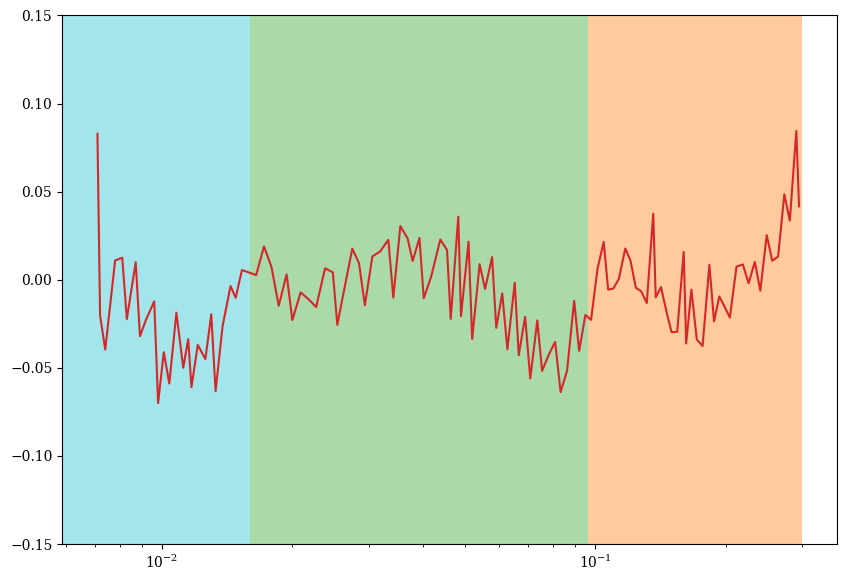

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7), dpi=100)

residual_GP = (data["I"][mask_fit_guinierANDporod] - GuinierANDPorod(data["q"]
                                                                     [mask_fit_guinierANDporod], *popt))/data["I"][mask_fit_guinierANDporod]
residual_pl = (data["I"][mask_fit_PL] - power_law2(data["q"]
                                                   [mask_fit_PL], *popt2))/data["I"][mask_fit_PL]

plt.plot(pd.concat([data["q"][mask_fit_PL], data["q"][mask_fit_guinierANDporod]]), pd.concat(
    [residual_pl, residual_GP]), c="tab:red")
xmin, xmax = ax.get_xlim()
plt.axvspan(xmin, q1, facecolor='tab:cyan', alpha=0.4)
plt.axvspan(q1, q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2, 0.3, facecolor='tab:orange', alpha=0.4)
plt.ylim(-0.15, 0.15)
plt.xscale("log")


### Fit only GP

[66.40901846  1.50279313 14.64271592  4.14778786]
q2:  0.09609851492894372  B:  0.00054317235738064


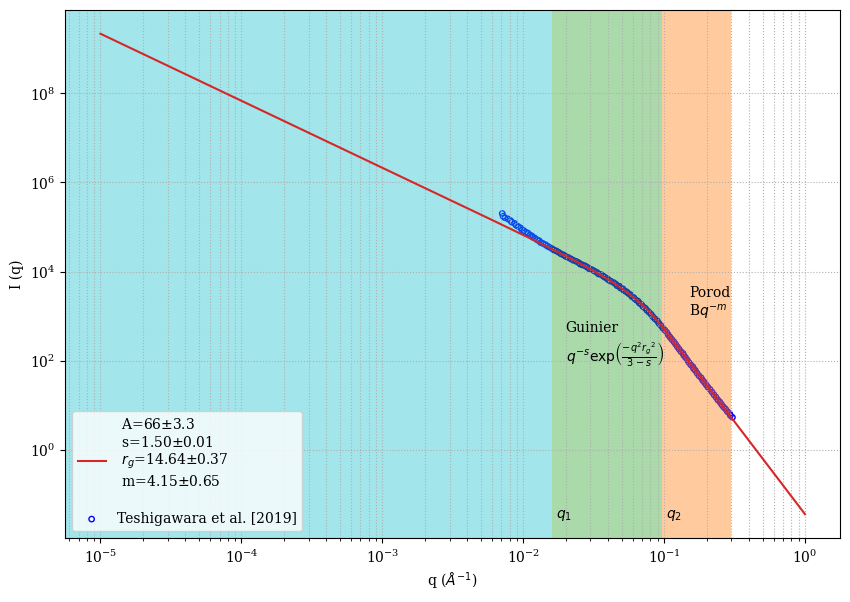

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7), dpi=100)
q1 = 0.016
mask_fit_PL = (data["q"] > 0.0072) & (data["q"] < q1)
mask_fit_guinierANDporod = (data["q"] > q1) & (data["q"] < 0.3)

popt, pcov = curve_fit(GuinierANDPorod,
                       data["q"][mask_fit_guinierANDporod],
                       data["I"][mask_fit_guinierANDporod],
                       p0=[1e2, 1.4, 16, 3.7, ],
                       bounds=((0, 1, 0, 3), (np.inf, np.inf, 20, 10))
                       )
perr = np.sqrt(np.diag(pcov))
print(popt)

plt.scatter(data["q"], data["I"], s=15, facecolors='none',
            edgecolors="b", label="Teshigawara et al. [2019]")

x_fit = [x for x in np.linspace(1e-5, 1, 1000)]
y_fit = GuinierANDPorod(pd.Series(x_fit), *popt)

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"

# Graphical decorators
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
# plt.vlines(q1,ymin,ymax)
ax.annotate(r'$q_1$',
            xy=(q1+0.001, 0.03)
            )
plt.axvspan(xmin, q1, facecolor='tab:cyan', alpha=0.4)
q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
B = np.power(q2, popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
print("q2: ", q2, " B: ", B)
# plt.vlines(q2,ymin,ymax)
ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$",
            xy=(0.02, 1e2)
            )
ax.annotate(f'$q_2$',
            xy=(q2+0.007, 0.03)
            )
plt.axvspan(q1, q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2, 0.3, facecolor='tab:orange', alpha=0.4)
ax.annotate('Porod\n'+r'B$q^{-m}$',
            xy=(0.15, 1e3)
            )
y_approx = [1.43934+x*(-00.55328) for x in x_fit]
plt.plot(x_fit, y_fit, c="tab:red", label=label_string_GP)
# plt.plot(x_fit,y_approx)
#plt.plot(x_fit2,y_fit2, c="tab:red",label=None)
plt.legend()
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("I (q)")
plt.yscale("log")
plt.grid(ls=":", which="both")
plt.savefig("Teshi_GP_only.png", dpi=300)
plt.show()


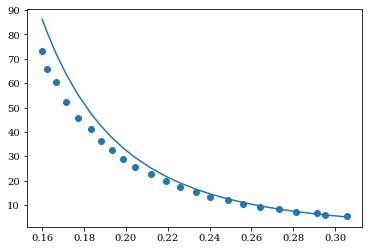

In [16]:
x = [0.1600,
     0.1621,
     0.1667,
     0.1715,
     0.1769,
     0.1834,
     0.1880,
     0.1933,
     0.1988,
     0.2045,
     0.2118,
     0.2191,
     0.2259,
     0.2335,
     0.2404,
     0.2487,
     0.2561,
     0.2642,
     0.2731,
     0.2812,
     0.2911,
     0.2953,
     0.3054]
y = [73.3235,
     65.9727,
     60.5311,
     52.3384,
     45.8544,
     41.3170,
     36.1124,
     32.6291,
     28.8805,
     25.5294,
     22.7149,
     19.7616,
     17.2231,
     15.1993,
     13.2499,
     11.8828,
     10.3672,
     9.1327,
     8.2556,
     7.2004,
     6.5849,
     5.9275,
     5.3606]

plt.scatter(x, y)
y_approx = [0.028*x0**(-4.38328) for x0 in x]
plt.plot(x, y_approx)


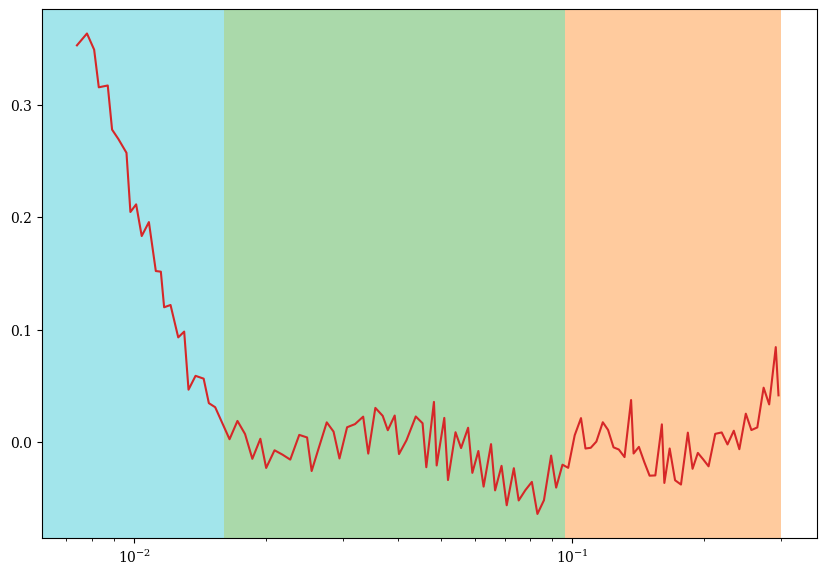

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7), dpi=100)

residual_GP = (data["I"][mask_fit_guinierANDporod] - GuinierANDPorod(data["q"]
                                                                     [mask_fit_guinierANDporod], *popt))/data["I"][mask_fit_guinierANDporod]
residual_pl = (data["I"][mask_fit_PL] - GuinierANDPorod(data["q"]
                                                        [mask_fit_PL], *popt))/data["I"][mask_fit_PL]

plt.plot(pd.concat([data["q"][mask_fit_PL], data["q"][mask_fit_guinierANDporod]]), pd.concat(
    [residual_pl, residual_GP]), c="tab:red")
xmin, xmax = ax.get_xlim()
plt.axvspan(xmin, q1, facecolor='tab:cyan', alpha=0.4)
plt.axvspan(q1, q2, facecolor='tab:green', alpha=0.4)
plt.axvspan(q2, 0.3, facecolor='tab:orange', alpha=0.4)
# plt.ylim(-0.15,0.15)
plt.xscale("log")


### Modeling for plugin

In [18]:
def first_Born_approx_q(x, R):
    b = 6.646E-05  # [AA] <- Carbon coherent scattering length
    n = 0.1771471666666667  # [at/AA^3] <- Diamond atom density
    physical_constant = 16*np.pi*np.pi*np.power(n*b, 2)  # [1/AA^4]
    R *= 10  # convert to AA
    osc_term = (np.sin(x*R) - x*R * np.cos(x*R)) * \
        (np.sin(x*R) - x*R * np.cos(x*R))
    # Determine the number of atoms in a diamon nanoparticle to normalize per-atoms
    # Nc = V * n = 4/3*pi*R^3 * n
    Nc = 0.7420 * R * R * R
    I = physical_constant*np.power(x, -6) * \
        osc_term / Nc * 1e8  # convert to barn
    return I
def first_Born_approx_q_dist(x, R_list, weights):
    I=0
    if np.abs(weights.sum()-1)>0.01:
        raise Exception("weights don´t sum to 1")
    for i,R in enumerate(R_list):
        I += first_Born_approx_q(x,R)*weights.iloc[i]
    return I

In [19]:
first_Born_approx_q(0.001,2.4)

4530.499660997624

In [116]:
filename= "aleksenskii_R_dist"
R_data = pd.read_csv(filename, names=["R","freq"],sep='\t')

In [117]:
R_data

,R,freq
0,0.648,0.001078
1,0.736,0.001197
2,0.839,0.002874
3,0.949,0.004311
4,1.069,0.006586
5,1.201,0.009340
6,1.357,0.013412
7,1.515,0.019159
8,1.699,0.027302
9,1.817,0.033649


In [118]:
first_Born_approx_q_dist(0.001,R_data["R"],R_data["freq"])

14293094.14418595

[66.40901846  1.50279313 14.64271592  4.14778786]
[2.12514024]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


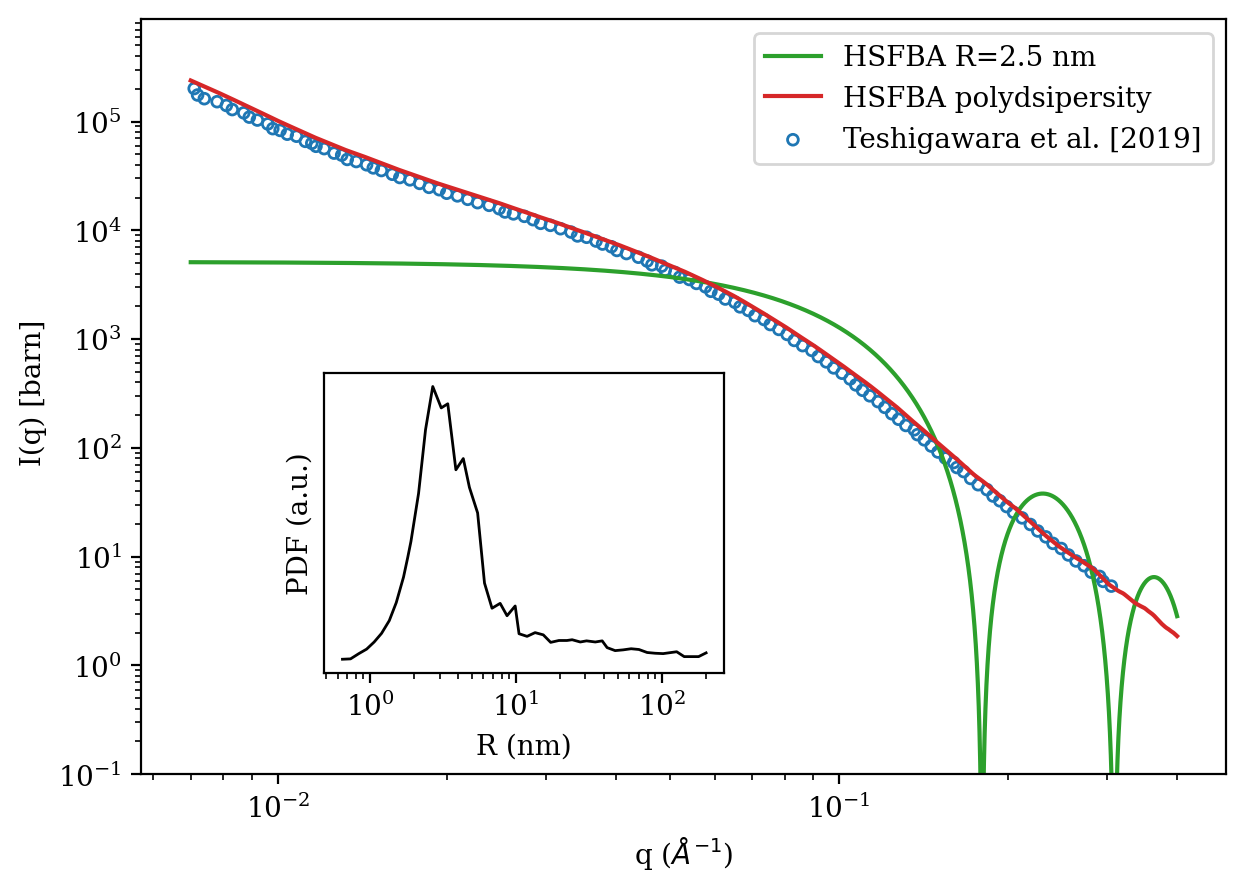

In [136]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=200)
q1 = 0.016
mask_fit_PL = (data["q"] > 0.0072) & (data["q"] < q1)
mask_fit_guinierANDporod = (data["q"] > q1) & (data["q"] < 0.3)

popt, pcov = curve_fit(GuinierANDPorod,
                       data["q"][mask_fit_guinierANDporod],
                       data["I"][mask_fit_guinierANDporod],
                       p0=[1e2, 1.4, 16, 3.7, ],
                       bounds=((0, 1, 0, 3), (np.inf, np.inf, 20, 10))
                       )
perr = np.sqrt(np.diag(pcov))
print(popt)


def power_law2(x, p):
    C = popt[0]*np.power(q1, p-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
    return C*np.power(x, -p)


popt2, pcov2 = curve_fit(power_law2,
                         data["q"][mask_fit_PL],
                         data["I"][mask_fit_PL],
                         p0=[1],
                         bounds=((0), (np.inf)))
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data["q"], data["I"], s=15, facecolors='none',
            edgecolors="tab:blue", label="Teshigawara et al. [2019]")
#plt.scatter(data_grammer["q"],data_grammer["I"],s=10,facecolors='none',edgecolors="r",label="Grammer and Gallmeier. [2020]")


x_fit = [x for x in np.linspace(q1, 0.4, 10000)]
y_fit = GuinierANDPorod(pd.Series(x_fit), *popt)
x_fit2 = [x for x in np.linspace(0.007, q1, 10000)]
y_fit2 = power_law2(pd.Series(x_fit2), *popt2)

A1 = 132.869
b1 = 1.33605
A2 = 0.0519763
b2 = 3.97314
Q0 = 0.0510821

x_fit_PPF = [x for x in np.logspace(np.log10(0.007), np.log10(0.4), 10000)]
y_fit_PPF = [piecewise_power(x, A1, b1, A2, b2, Q0) for x in x_fit_PPF]
y_HSFBA = [first_Born_approx_q(q, 2.5) for q in x_fit_PPF]
y_HSFBA_multi = [first_Born_approx_q_dist(q, R_data["R"],R_data["freq"]) for q in x_fit_PPF]

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"
label_string_pl = f" p={popt2[0]:.2f}$\pm${perr2[0]:.2f}"

# Graphical decorators
#ymin, ymax = ax.get_ylim()
#xmin, xmax = ax.get_xlim()
# plt.vlines(q1,ymin,ymax)
# ax.annotate(r'$q_1$',
#            xy=(q1+0.001,0.03)
#           )
# ax.annotate('Power Law\n'+r'C$q^{-p}$',
#            xy=(0.006,1e3)
#            )
#plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
#q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
#B = np.power(q2,popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
#C = popt[0]*np.power(q1,popt2[0]-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
#print("q2: ",q2, " C: ",C, " B: ",B)
#print("Relative diff. @q2: ",(GuinierANDPorod(pd.Series([0.015]),*popt)[0] - power_law2(pd.Series([0.015]),*popt2)[0])/GuinierANDPorod(pd.Series([0.015]),*popt)[0])
# plt.vlines(q2,ymin,ymax)
# ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$",
#            xy=(0.02,1e2)
#            )
# ax.annotate(f'$q_2$',
#            xy=(q2+0.007,0.03)
#            )
#plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
#plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
# ax.annotate('Porod\n'+r'B$q^{-m}$',
#            xy=(0.15,1e3)
#            )

#plt.plot(x_fit, y_fit, c="tab:orange", label=label_string_GP+label_string_pl)
#plt.plot(x_fit2, y_fit2, c="tab:orange", label=None)
#plt.plot(x_fit_PPF, y_fit_PPF, c="tab:green", label="PPF")
plt.plot(x_fit_PPF, y_HSFBA, c="tab:green",
         label="HSFBA R={} nm ".format(2.5))
plt.plot(x_fit_PPF, y_HSFBA_multi, c="tab:red",
         label="HSFBA polydsipersity")
plt.legend()
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel(" I(q) [barn]")
plt.yscale("log")
plt.gca().set_ylim(bottom=1e-1)
#plt.grid(ls=":", which="both")

#this is the small figure
ins_ax = inset_axes(ax, width=2, height=1.5,
          bbox_transform=ax.transAxes, bbox_to_anchor=(0.55,0.55),)
ins_ax.plot(R_data["R"],R_data["freq"],color="k",lw=1)
ins_ax.set_xscale("log")
ins_ax.tick_params(axis="both", which="both",left=False, right=False, bottom=True, labelleft=False, labelbottom=True)
ins_ax.set_xlabel("R (nm)")
ins_ax.set_ylabel("PDF (a.u.)")
plt.savefig("Iq_comparison_HSFBA.png", dpi=200)
plt.savefig("Iq_comparison_HSFBA.eps", dpi=200)
plt.show()


In [109]:
R=25

In [110]:
Vp = 4/3*np.pi*R*R*R

In [115]:
SLD = 2.34e-6 #AA-2

Nc = 0.7420 * R * R * R

Vp*Vp*SLD*SLD*1e8/Nc

13.30135364028215

[66.40901846  1.50279313 14.64271592  4.14778786]
[2.12514024]


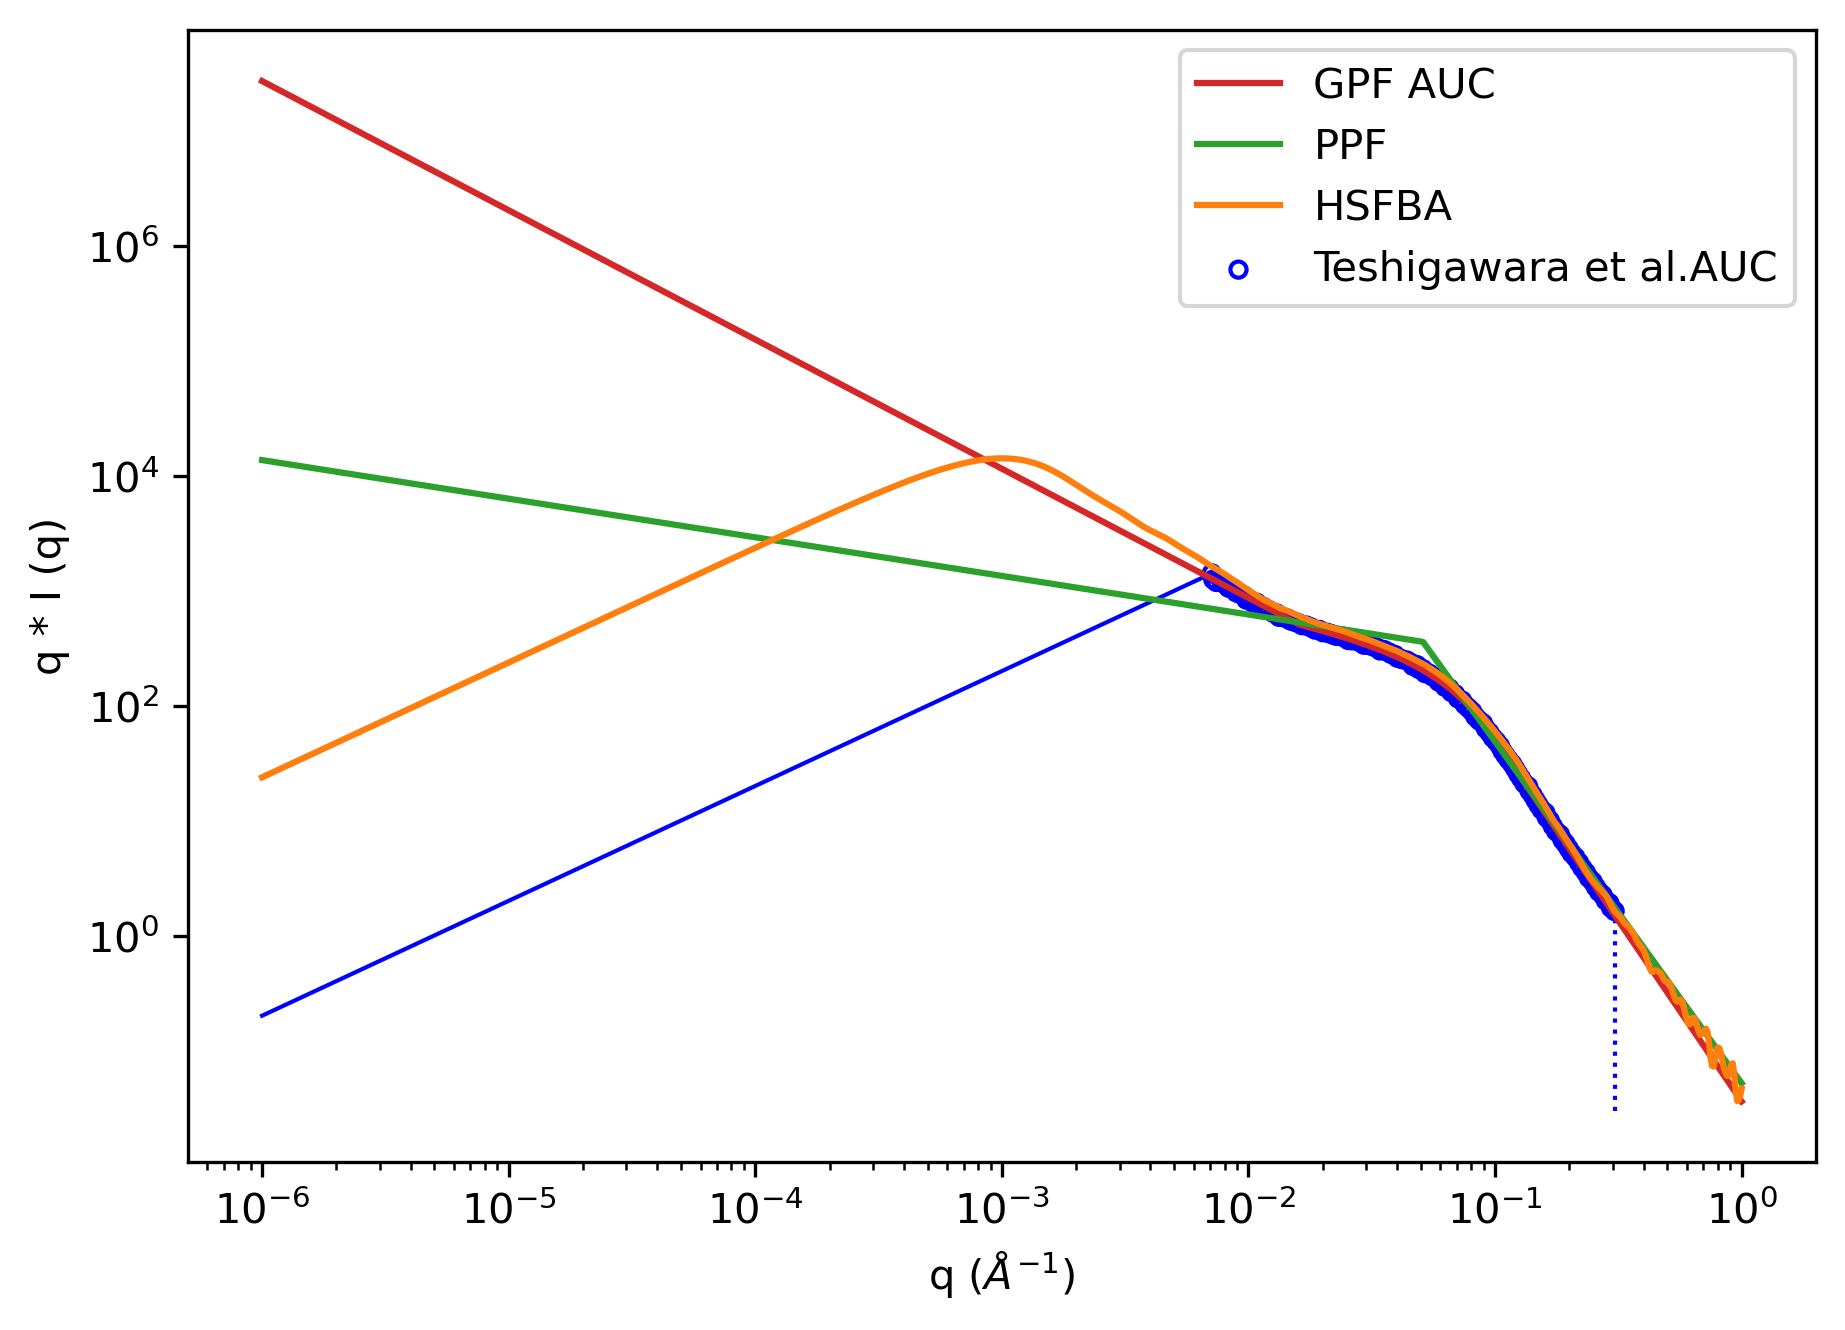

In [84]:
from sklearn.metrics import auc
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)
q1 = 0.016
mask_fit_PL = (data["q"] > 0.0072) & (data["q"] < q1)
mask_fit_guinierANDporod = (data["q"] > q1) & (data["q"] < 0.3)

popt, pcov = curve_fit(GuinierANDPorod,
                       data["q"][mask_fit_guinierANDporod],
                       data["I"][mask_fit_guinierANDporod],
                       p0=[1e2, 1.4, 16, 3.7, ],
                       bounds=((0, 1, 0, 3), (np.inf, np.inf, 20, 10))
                       )
perr = np.sqrt(np.diag(pcov))
print(popt)


def power_law2(x, p):
    C = popt[0]*np.power(q1, p-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
    return C*np.power(x, -p)


popt2, pcov2 = curve_fit(power_law2,
                         data["q"][mask_fit_PL],
                         data["I"][mask_fit_PL],
                         p0=[1],
                         bounds=((0), (np.inf)))
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

#plt.scatter(data_grammer["q"],data_grammer["I"]*data_grammer["q"],s=15,facecolors='none',edgecolors="r",label="Grammer and Gallmeier")

x_fit = [x for x in np.logspace(np.log10(q1), 0, 1000)]
y_fit = GuinierANDPorod(pd.Series(x_fit), *popt)
y_fit = x_fit*y_fit
x_fit2 = [x for x in np.logspace(-6, np.log10(q1), 1000)]
y_fit2 = power_law2(pd.Series(x_fit2), *popt2)
y_fit2 = x_fit2*y_fit2
A1 = 132.869
b1 = 1.33605
A2 = 0.0519763
b2 = 3.97314
Q0 = 0.0510821

x_fit_PPF = [x for x in np.logspace(-6, 0, 1000)]
y_fit_PPF = [x*piecewise_power(x, A1, b1, A2, b2, Q0) for x in x_fit_PPF]
y_HSFBA = [q*first_Born_approx_q(q, 2.4) for q in x_fit_PPF]
y_HSFBA_multi = [q*first_Born_approx_q_dist(q, R_data["R"],R_data["freq"]) for q in x_fit_PPF]

label_string_GP = f" A={popt[0]:.0f}$\pm${perr[0]:.1f}\n s={popt[1]:.2f}$\pm${perr[1]:.2f}\n $r_g$={popt[2]:.2f}$\pm${perr[2]:.2f}\n m={popt[3]:.2f}$\pm${perr[3]:.2f}\n"
label_string_pl = f" p={popt2[0]:.2f}$\pm${perr2[0]:.2f}"

# Graphical decorators
#ymin, ymax = ax.get_ylim()
#xmin, xmax = ax.get_xlim()
# plt.vlines(q1,ymin,ymax)
# ax.annotate(r'$q_1$',
#            xy=(q1+0.001,0.03)
#           )
# ax.annotate('Power Law\n'+r'C$q^{-p}$',
#            xy=(0.006,1e3)
#            )
#plt.axvspan(xmin,q1, facecolor='tab:cyan', alpha=0.4)
#q2 = 1.0/popt[2]*np.sqrt((popt[3]-popt[1])*(3-popt[1])/2)
#B = np.power(q2,popt[3]-popt[1])*np.exp((-q2**2*popt[2]**2)/(3-popt[1]))
#C = popt[0]*np.power(q1,popt2[0]-popt[1])*np.exp((-q1**2*popt[2]**2)/(3-popt[1]))
#print("q2: ",q2, " C: ",C, " B: ",B)
#print("Relative diff. @q2: ",(GuinierANDPorod(pd.Series([0.015]),*popt)[0] - power_law2(pd.Series([0.015]),*popt2)[0])/GuinierANDPorod(pd.Series([0.015]),*popt)[0])
# plt.vlines(q2,ymin,ymax)
# ax.annotate("Guinier\n"+r"$q^{-s}\exp\left(\frac{-q^2r{_g}{^2}}{3-s}\right)$",
#            xy=(0.02,1e2)
#            )
# ax.annotate(f'$q_2$',
#            xy=(q2+0.007,0.03)
#            )
#plt.axvspan(q1,q2, facecolor='tab:green', alpha=0.4)
#plt.axvspan(q2,0.3, facecolor='tab:orange', alpha=0.4)
# ax.annotate('Porod\n'+r'B$q^{-m}$',
#            xy=(0.15,1e3)
#            )
x_added = np.logspace(-6, np.log10(data["q"].iat[0]), 10000)
y_added = [data["I"].iat[0]*x for x in x_added]
plt.plot(x_added, y_added, color="b", linewidth=1)
plt.vlines(x=data["q"].iat[-1], ymin=3e-2, ymax=data["I"].iat[-1] *
           data["q"].iat[-1], color="b", linewidth=1, linestyles=":", zorder=0)

#AUC_PPF = auc(x_fit_PPF, y_fit_PPF)
#AUC_GPF = auc(x_fit2+x_fit, y_fit2.append(y_fit))
#AUC_TESHI = auc(np.append(x_added, data["q"].values), np.append(
#    y_added, data["q"].values*data["I"].values))
#AUC_HSFBA = auc(x_fit_PPF, y_HSFBA)
#print("AUC_PPF ", AUC_PPF)
#print("AUC_GPF ", AUC_GPF)
#print("AUC_TESHI", AUC_TESHI)
#print("AUC_HSFBA", AUC_HSFBA)

plt.scatter(data["q"], data["I"]*data["q"], s=15, facecolors='none',
            edgecolors="b", label="Teshigawara et al.AUC")
# plt.hlines(y=data_ersez["I"].iat[0]*data_ersez["q"].iat[0],xmin=1e-6,xmax=data_ersez["q"].iat[0],color="r",linewidth=1,linestyles=":",zorder=0)
# plt.vlines(x=data_ersez["q"].iat[-1],ymin=3e-2,ymax=data_ersez["I"].iat[-1]*data_ersez["q"].iat[-1],color="r",linewidth=1,linestyles=":",zorder=0)
plt.plot(x_fit2+x_fit, y_fit2.append(y_fit), c="tab:red",
         label="GPF AUC")
#plt.plot(x_fit2,y_fit2, c="tab:orange",label=None)
plt.plot(x_fit_PPF, y_fit_PPF, c="tab:green",
         label="PPF")
plt.plot(x_fit_PPF,y_HSFBA_multi, c="tab:orange",label="HSFBA")

plt.legend()
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("q * I (q)")
plt.yscale("log")
# plt.grid(ls=":",which="both")
# plt.savefig("Teshi_GP_and_PL.png",dpi=300)
plt.show()


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100)
cumsumPPF = pd.Series(y_fit_PPF).cumsum()
cumsumHSFBA = pd.Series(y_HSFBA).cumsum()
cumsumGPF = y_fit2.append(y_fit, ignore_index=True).cumsum()
cumsumTeshi = np.append(y_added, data["q"].values*data["I"].values).cumsum()
plt.plot(x_fit2+x_fit, cumsumGPF, color="tab:red")
plt.plot(x_fit_PPF, cumsumPPF, color="g")
plt.plot(x_fit_PPF, cumsumHSFBA, color="tab:orange")
plt.plot(np.append(x_added, data["q"].values), cumsumTeshi, color="b")
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("q * I (q)")
# plt.yscale("log")
plt.show()


In [ ]:
plt.plot(x_fit2+x_fit, cumsumGPF/cumsumGPF.iloc[-1], color="tab:red")
plt.plot(x_fit_PPF, cumsumPPF/cumsumPPF.iloc[-1], color="g")
plt.plot(x_fit_PPF, cumsumHSFBA/cumsumHSFBA.iloc[-1], color="tab:orange")
plt.plot(np.append(x_added, data["q"].values),
         cumsumTeshi/cumsumTeshi[-1], color="b")
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("q * I (q)")
# plt.yscale("log")
plt.ylim((0, 1.1))
plt.show()


In [ ]:
def calc_int_Iq(k):
    A1 = 132.869
    b1 = 1.33605
    A2 = 0.0519763
    b2 = 3.97314
    Q0 = 1e-5
    Q1 = 0.0510821
    I_Q0 = A1 * np.power(Q0, -b1)
    return Q0*I_Q0 + A1/(-b1+1)*np.power(Q1, -b1+1) - A1/(-b1+1)*np.power(Q0, -b1+1) + A2/(-b2+1)*np.power(2*k, -b2+1) - A2/(-b2+1)*np.power(Q1, -b2+1)


def sample_q_from_Iq(rand, k):
    A1 = 132.869
    b1 = 1.33605
    A2 = 0.0519763
    b2 = 3.97314
    Q1 = 0.0510821
    Q0 = 1e-5
    norm = calc_int_Iq(k)  # cross section over total cross section ratio
    I_Q0 = A1 * np.power(Q0, -b1)
    CDF_Q0 = Q0*I_Q0/norm
    CDF_Q1 = (Q0*I_Q0 + A1 * np.power(Q1, -b1 + 1) / (-b1 + 1) -
              A1 * np.power(Q0, -b1 + 1) / (-b1 + 1)) / norm

    if rand < CDF_Q0:
        Q = rand*norm/I_Q0
    elif rand < CDF_Q1:
        Q = np.power((rand * norm - Q0*I_Q0 + A1/(-b1+1) *
                    np.power(Q0, -b1+1))*(-b1+1)/A1, 1 / (-b1 + 1))
    else:
        Q = np.power((rand * norm - Q0*I_Q0 + A1/(-b1+1)*np.power(Q0, -b1+1) - A1/(-b1+1)
                    * np.power(Q1, -b1+1) + A2/(-b2+1)*np.power(Q1, -b2+1))*(-b2+1)/A2, 1 / (-b2 + 1))
    return Q


In [ ]:
qvals = []
nbins = 200
n = 0
while n < 1e6:
    k = 0.3
    r = np.random.uniform()
    qvals.append(sample_q_from_Iq(r, k))
    n += 1

In [ ]:
##FIT CURVE###
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100)
def piecewise_power(x, A1, b1, A2, b2):
    result = x.copy()
    mask = result < 0.051
    result[mask] = A1*np.power(x, -b1)
    result[np.invert(mask)] = A2*np.power(x, -b2)
    return result


popt, pcov = curve_fit(piecewise_power,
                       pd.Series(bins[100:-10]),
                       pd.Series(values[100:-9]),
                       p0=[1e2, 1.33, 0.05, 3.97]
                       #bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                       )
perr = np.sqrt(np.diag(pcov))
print(popt)
x_fit_PPF = [x for x in np.logspace(-6, 0, nbins)]
y_fit_PPF = piecewise_power(pd.Series(x_fit_PPF), *popt)
plt.plot(x_fit_PPF, y_fit_PPF, c="tab:red", label=None, linestyle=":")
values, bins, _ = plt.hist(qvals, alpha=0.5, bins=np.logspace(-6, 0, nbins),
                           label=f'PPF', color="k", fill=False, histtype="step", density=True)
plt.xscale("log")
plt.xlabel("q ($Å^{-1}$)")
plt.ylabel("I (q)")
plt.yscale("log")

### Simple model fit

In [ ]:
def simple(x, A):
    return A * 25.3e-3/x

In [ ]:
cols = ["E", "xs"]
data_vesuvio = pd.read_csv("vesuvio.dat", names=cols, sep=" ", skiprows=1)
data_teshi_xs = pd.read_csv("teshi.dat", names=cols, sep=" ", skiprows=1)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)
E_fit = 4e-3
mask_vesuvio = data_vesuvio["E"] < E_fit
mask_teshi = data_teshi_xs["E"] < E_fit
popt, pcov = curve_fit(simple,
                       data_vesuvio["E"][mask_vesuvio],
                       data_vesuvio["xs"][mask_vesuvio],
                       p0=[8],
                       #bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                       )
perr = np.sqrt(np.diag(pcov))
print(popt)

popt2, pcov2 = curve_fit(simple,
                         data_teshi_xs["E"][mask_teshi],
                         data_teshi_xs["xs"][mask_teshi],
                         p0=[8],
                         #bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                         )
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data_vesuvio["E"], data_vesuvio["xs"], s=10,
            facecolors='none', edgecolors="tab:red", label="VESUVIO exp")
plt.scatter(data_teshi_xs["E"], data_teshi_xs["xs"], s=10,
            facecolors='none', edgecolors="tab:green", label="Teshi xs")

x_fit = [x for x in np.logspace(-4, -1, 1000)]
y_fit = simple(pd.Series(x_fit), *popt)
y_fit2 = simple(pd.Series(x_fit), *popt2)


label_string = f" A={popt[0]:.2f}$\pm${perr[0]:.2f}"
label_string2 = f" A={popt2[0]:.2f}$\pm${perr2[0]:.2f}"
plt.plot(x_fit, y_fit, c="tab:orange", label=label_string)
plt.plot(x_fit, y_fit2, c="tab:blue", label=label_string2)

xmin, xmax = ax.get_xlim()
plt.axvspan(xmin, E_fit, facecolor='tab:cyan', alpha=0.2)

plt.xlim(1e-4, 1e-1)
plt.legend()
plt.xscale("log")
plt.xlabel("E (eV)")
plt.ylabel("Cross Section (barn)")
plt.yscale("log")
# plt.grid(ls=":",which="both")
# plt.savefig("Teshi_GP_and_PL.png",dpi=300)
plt.show()


In [194]:
def first_Born_approx_k(x, R):
    k = 0.6947*np.sqrt(x*1e+3)
    # h_bar = 1.054571817e-34 ;//[J*s] <- Reduced planck constant
    # m = 1.674927498e-27;// [Kg] <- neutron mass
    # V = 290.0e-9*1.60218e-19;// [J]
    # 2*pi*(2mV/h_bar^2)^2 =   1.2307e+33 [1/m^4]
    #physical_constant = 1.2307e-07
    physical_constant = 32*np.pi*np.pi*np.pi*np.power(n*b, 2)  # [1/AA^4]
    R *= 10  # converto to AA
    _2kr = 2 * k * R
    I = 0.25 * (1 - 1 / (_2kr * _2kr) + np.sin(2 * _2kr) / (_2kr * _2kr *
                                                            _2kr) - np.sin(_2kr) * np.sin(_2kr) / (_2kr * _2kr * _2kr * _2kr))
     # Determine the number of atoms in a diamon nanoparticle to normalize per-atoms
    # Nc = V * n = 4/3*pi*R^3 * n
    Nc = 0.7420 * R * R * R
    SANS_xs = physical_constant * \
        np.power(R, 6) / (k * k * R * R) * I / Nc * 1e8  # convert to barn
    return SANS_xs


In [200]:
b = 6.646E-05  # [AA] <- Carbon coherent scattering length
n = 0.1771471666666667  # [at/AA^3] <- Diamond atom density
32*np.pi*np.pi*np.pi*np.power(n*b, 2)

1.375272285972827e-07

In [195]:
def first_Born_approx_q(x, R):
    b = 6.646E-05  # [AA] <- Carbon coherent scattering length
    n = 0.1771471666666667  # [at/AA^3] <- Diamond atom density
    physical_constant = 16*np.pi*np.pi*np.power(n*b, 2)  # [1/AA^4]
    R *= 10  # convert to AA
    osc_term = (np.sin(x*R) - x*R * np.cos(x*R)) * \
        (np.sin(x*R) - x*R * np.cos(x*R))
    # Determine the number of atoms in a diamon nanoparticle to normalize per-atoms
    # Nc = V * n = 4/3*pi*R^3 * n
    Nc = 0.7420 * R * R * R
    I = physical_constant*np.power(x, -6) * \
        osc_term / Nc * 1e8  # convert to barn
    return I

In [196]:
first_Born_approx_k(0.001,2.5)

239.83562619707115

In [204]:
def cos_approx(x):
    return (1-0.5*x*x),np.cos(x),abs((1-0.5*x*x) - np.cos(x))

In [211]:
cos_approx(1.5)

(-0.125, 0.0707372016677029, 0.19573720166770292)

In [ ]:
print(np.power(24*1e-10, 6)*1.2307e+33/(k*k*24*24)/4*1e24)


In [ ]:
k = 0.6947*np.sqrt(0.5*1e+3)
print(np.power(24, 6)*1.2307e-07/(k*k*24*24)/4*1e4)


In [ ]:
first_Born_approx_k(0.5, 2.4)


In [ ]:
import scipy.constants as c
2*c.pi*c.hbar*c.hbar/c.m_n*6.65*c.femto*1.7602606161532054e+17


In [ ]:
c.Avogadro


In [ ]:
def en2k(x):
    return 0.6947*np.sqrt(x*1e+3)


In [ ]:
def rolando(x, R):
    return 0.006872*np.power(R, 4.015)/x


In [ ]:
physical_constant = 1.2307e+33  # [1/m^4]
energy_conv_const = (.6947*.6947)  # [AA^2/meV]
print(physical_constant*1e-40/4/energy_conv_const)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)
E_fit = 4e-3
mask_vesuvio = data_vesuvio["E"] < E_fit
mask_teshi = data_teshi_xs["E"] < E_fit
popt, pcov = curve_fit(first_Born_approx,
                       data_vesuvio["E"][mask_vesuvio],
                       data_vesuvio["xs"][mask_vesuvio],
                       p0=[0.2],
                       #bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                       )
perr = np.sqrt(np.diag(pcov))
print(popt)

popt2, pcov2 = curve_fit(first_Born_approx,
                         data_teshi_xs["E"][mask_teshi],
                         data_teshi_xs["xs"][mask_teshi],
                         p0=[0.2],
                         #bounds=((0, 1, 0, 3),(np.inf,np.inf,20, 10))
                         )
perr2 = np.sqrt(np.diag(pcov2))
print(popt2)

plt.scatter(data_vesuvio["E"], data_vesuvio["xs"], s=10,
            facecolors='none', edgecolors="tab:red", label="VESUVIO exp")
plt.scatter(data_teshi_xs["E"], data_teshi_xs["xs"], s=10,
            facecolors='none', edgecolors="tab:green", label="Teshi xs")

x_fit = [x for x in np.logspace(-4, -1, 10000)]
y_fit = first_Born_approx(pd.Series(x_fit), *popt)
y_fit2 = first_Born_approx(pd.Series(x_fit), *popt2)


label_string = f" R={popt[0]:.3f}$\pm${perr[0]:.3f}"
label_string2 = f" R={popt2[0]:.3f}$\pm${perr2[0]:.3f}"
plt.plot(x_fit, y_fit, c="tab:orange", label=label_string)
plt.plot(x_fit, y_fit2, c="tab:blue", label=label_string2)

xmin, xmax = ax.get_xlim()
plt.axvspan(xmin, E_fit, facecolor='tab:cyan', alpha=0.2)

plt.xlim(1e-4, 1e-1)
plt.legend()
plt.xscale("log")
plt.xlabel("E (eV)")
plt.ylabel("Cross Section (barn)")
plt.yscale("log")
# plt.grid(ls=":",which="both")
plt.savefig("FirstBornApp_xs.png", dpi=300)
plt.show()


### OLD

In [ ]:
from scipy.special import gammaincc, gamma, gammainc


def gamma_inc(a, x):
    return gamma(a)*gammaincc(a, x)


def indef_int_guinier(q):
    A = 67.47
    s = 1.5
    rg = 14.73173127
    c = rg**2/(3-s)
    if(q != 0):
        return -(c)**(s/2-1)*gamma_inc(1-s/2, c*q**2)/2
    else:
        return -(c**(s/2-1)*gamma(1-s/2))/2


def indef_int_guinier2(q):
    A = 67.47
    s = 1.5
    rg = 14.73173127
    c = rg**2/(3-s)
    return (c)**(s/2-1)*gamma(1-s/2)*gammainc(1-s/2, c*q**2)/2


In [ ]:
(indef_int_guinier(0.0072) - indef_int_guinier(0))


In [ ]:
indef_int_guinier2(0.0072)
